In [1]:
import numpy as np
from keras import backend as K
from keras.layers import Input, MaxPool2D, Conv2D, UpSampling2D, \
    Concatenate, Maximum, Add, Activation, Lambda, BatchNormalization, Softmax
from keras.models import Model
from keras.activations import softmax
import math
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

from utils import *

Using TensorFlow backend.


(1024, 1224, 3)


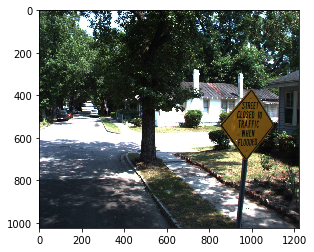

In [2]:
im = cv2.imread("test3.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)
plt.imshow(im)

In [3]:
angle_count = 8
edge_kernel_size = 7
line_detection_filter_size = 5
square_detection_square_size_count = 1
square_detection_min_square_size = 5
square_detection_max_square_size = 5
square_detection_kernel_size = 13
detection_filter_filter_size = 5
detection_filter_dmz_size = 1
detection_filter_penality = -0.1
score_filter_size = 5
size_filter_size = 5
first_pyramid_output = 2
pyramid_depth = 7
scale_initial_value = 1000

In [4]:
height, width, _ = im.shape
size = [height, width]
k = math.pow(2, pyramid_depth)
for i, v in enumerate(size):
    v -= (v - edge_kernel_size + 1) % k
    size[i] = int(v)
height, width = size

input_layer = Input(shape=(height,width,3))
edge_layer, edge_weights, edge_bias = get_edge_layer_and_weights(input_filters=3,
                                                                 kernel_size=edge_kernel_size,
                                                                 filters_count=angle_count,
                                                                 padding='valid')
line_layer, line_weights, line_bias = get_line_detection_layer_and_weights(filter_count=angle_count, 
                                                                           angle_increment=math.pi*2/angle_count, 
                                                                           filter_size=line_detection_filter_size)
square_layer, square_weights, square_bias = get_square_detection_layer_and_weights(input_filter_count=angle_count, 
                                                                                   filter_count=square_detection_square_size_count, 
                                                                                   min_square_size=square_detection_min_square_size, 
                                                                                   max_square_size=square_detection_max_square_size, 
                                                                                   kernel_size=square_detection_kernel_size)
max_pool_layer = MaxPool2D(pool_size=(2, 2), padding='same')


filter_layer, filter_weights, filter_bias = get_detection_filter_layer_and_weights(filter_count=pyramid_depth - first_pyramid_output, 
                                                                                   dmz_size=detection_filter_dmz_size, 
                                                                                   other_penality=detection_filter_penality, 
                                                                                   filter_size=detection_filter_filter_size)

score_layer, score_weights, score_bias = get_score_layer_and_weights(input_filter=pyramid_depth - first_pyramid_output,
                                                                     filter_size=score_filter_size,
                                                                     activation='sigmoid'
                                                                    )

size_layer, size_weights, size_bias = get_size_layer_and_weights(input_filter=pyramid_depth - first_pyramid_output,
                                                                 filter_size=size_filter_size,
                                                                 first_filter_size=line_detection_filter_size,
                                                                 filter_size_factor=2)


In [5]:
edges = edge_layer(input_layer)
line = line_layer(edges)
pool = max_pool_layer(line)
pyramid = [pool,]
for i in range(1, pyramid_depth):
    line = line_layer(pyramid[-1])
    pool = max_pool_layer(line)
    pyramid.append(pool)
    
squares = [square_layer(l) for l in pyramid[first_pyramid_output:]]

upsamplings = []
for i, s in enumerate(squares):
    n = math.pow(2, i)
    up = UpSampling2D(size=(n, n), interpolation='bilinear')(s)
    upsamplings.append(up)
    
concat = Concatenate(axis=3)(upsamplings)

filtered = filter_layer(concat)

score = score_layer(filtered)

scale_factor = tf.Variable(scale_initial_value, name='scale_factor', dtype=np.float32)
size_score = Lambda(lambda x: x * scale_factor)(filtered)
size_score = Softmax(axis=-1, name="SoftmaxNorm")(size_score)
# size_score = Normalisation(axis=-1, name="Normalisation")(filtered)
# size_score = BatchNormalization(axis=-1)(filtered)
size = size_layer(size_score)


In [6]:
model = Model(inputs=input_layer, outputs=[score, size])
# model.compile("SGD", loss='mse')

model.get_layer("EdgeDetector").set_weights((edge_weights, edge_bias))
model.get_layer("LineDetector").set_weights((line_weights, line_bias))
model.get_layer("SquareDetector").set_weights((square_weights, square_bias))
model.get_layer("DetectionFiltering").set_weights((filter_weights, filter_bias))
model.get_layer("Score").set_weights((score_weights, score_bias))
model.get_layer("Size").set_weights((size_weights, score_bias))

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 902, 1158, 3) 0                                            
__________________________________________________________________________________________________
EdgeDetector (Conv2D)           (None, 896, 1152, 8) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
LineDetector (Conv2D)           multiple             1608        EdgeDetector[0][0]               
                                                                 max_pooling2d_1[0][0]            
                                                                 max_pooling2d_1[1][0]            
                                                                 max_pooling2d_1[2][0]            
          

In [7]:
input_image = cv2.resize(im, (width, height))
input_image = input_image.astype(np.float).reshape((1,) + input_image.shape)
input_image /= input_image.max()
print(input_image.shape, input_image.max(), input_image.min())
pred_list = model.predict(input_image)
try:
    pred_list = pred_list.reshape((-1,) + pred_list.shape)
except AttributeError:
    pass
# print(pred.shape)

(1, 902, 1158, 3) 1.0 0.0


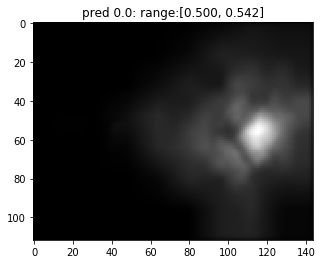

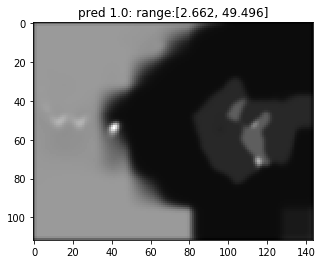

In [8]:
for n, pred in enumerate(pred_list):
    # print("pred {}: {}".format(n, pred.shape))
    pred_norm = pred - pred.min()
    pred_norm = pred_norm / pred_norm.max()
    for i in range(pred.shape[-1]):
        plt.imshow(pred_norm[0, :, :, i], cmap='gray')
        plt.title("pred {}.{}: range:[{:.3f}, {:.3f}]".format(n,i,
                                                              pred[0, :, :, i].min(),
                                                              pred[0, :, :, i].max()))
        plt.show()

In [9]:
pos = np.unravel_index(np.argmax(pred_list[0][0,:,:,0]), pred_list[0].shape[1:3])
print(pos, pred_list[0].shape)
print(pred_list[0][0, pos[0], pos[1], 0])
sz = pred_list[1][0, pos[0], pos[1], 0]
print("Prediction: x={}, y={}, size={}".format(pos[1], pos[0], sz))

(55, 115) (1, 112, 144, 1)
0.5416178
Prediction: x=115, y=55, size=20.046985626220703


(1024, 1224, 3) (112, 144)


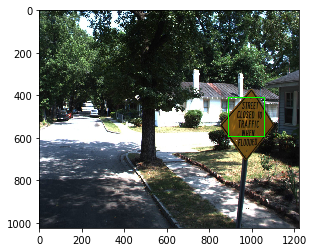

170.39937782287598 183.28672572544642


In [10]:
print(im.shape, pred_list[0].shape[1:3])
fx = im.shape[1] / pred_list[0].shape[2]
fy = im.shape[0] / pred_list[0].shape[1]
p1 = tuple([int(round(v)) for v in ((pos[1] - sz/2) * fx, (pos[0] - sz/2) * fy)])
p2 = tuple([int(round(v)) for v in ((pos[1] + sz/2) * fx, (pos[0] + sz/2) * fy)])
bb_im = cv2.rectangle(im.copy(), p1, p2, (0, 255, 0), 4)
plt.imshow(bb_im)
plt.show()
print(sz * fx, sz * fy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


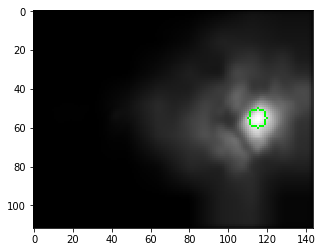

In [11]:
score_im = pred_list[0][0,:,:,0].copy()
score_im -= score_im.min()
score_im = score_im / score_im.max()
score_im = cv2.cvtColor(score_im, cv2.COLOR_GRAY2RGB)
score_im = cv2.circle(score_im, (pos[1], pos[0]), 5, (0, 255, 0), 1)
plt.imshow(score_im)
plt.show()

In [12]:
for p in pred_list:
    print(p.shape)

(1, 112, 144, 1)
(1, 112, 144, 1)


In [13]:
#print(pred_list[3].shape)
#for i in range(pred_list[3].shape[-1]):
#    print(pred_list[3][0 ,pos[0], pos[1], i])

In [14]:
#print(pred_list[2].shape)
#for i in range(pred_list[2].shape[-1]):
#    print(pred_list[2][0 ,pos[0], pos[1], i])

# Large scale tests

In [15]:
from metrics import recall
from load_yolo_data import load_annotations_from_dir
from loss import detection_loss

In [16]:
size = [height, width]
#size = [1920 / 2, 1080 / 2]
#k = math.pow(2, pyramid_depth)
#for i, v in enumerate(size):
#    v -= (v - edge_kernel_size + 1) % k
#    size[i] = int(v)
#print(size)
annotation_shape = model.layers[-1].output_shape[1:3]
print(size, annotation_shape)

[902, 1158] (112, 144)


In [17]:
x, (y_score, y_size) = load_annotations_from_dir("data/curve", size, annotation_shape, "*.jpg")

47 images found in data/curve


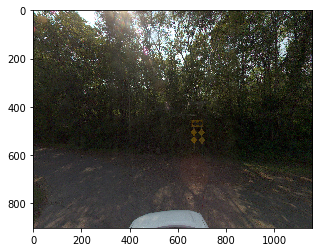

In [18]:
plt.imshow(x[0])

In [19]:
model.compile(optimizer='sgd',
              loss=detection_loss())

In [20]:
model.evaluate(x, y=[y_score, y_size], batch_size=1)

47/47 [==============================] - 3s 69ms/step


[1.576634608684702, 0.1777241417068116, 1.398910457307988]

In [21]:
np.max(y_size)

16.5

In [22]:
np.max(y_score)

1.0